In [1]:
%matplotlib inline
import pennylane as qml
import torch
import torch.autograd as autograd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np
from IPython import display

# QCiruits parameter
n_wires = 4
n_layers = 4

# ODE parameter
lmbda_1 = 5
lmbda_2 = 3

@qml.qnode(qml.device("default.qubit", wires=n_wires), diff_method="best")
def circuit_1(x, weights):
    # Embedding
    for i in range(n_wires):
        qml.RY(2*i*torch.arccos(x),wires = i)
    # Variational ansatz
    qml.BasicEntanglerLayers(weights=weights, wires=range(n_wires))
    # Cost function
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

@qml.qnode(qml.device("default.qubit", wires=n_wires), diff_method="best")
def circuit_2(x, weights):
    # Embedding
    for i in range(n_wires):
        qml.RY(2*i*torch.arccos(x),wires = i)
    # Variational ansatz
    qml.BasicEntanglerLayers(weights=weights, wires=range(n_wires))
    # Cost function
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

def my_model(x, weights, biases):
    vcircuit_1 = torch.vmap(circuit_1, in_dims=(0,None))
    vcircuit_2 = torch.vmap(circuit_2, in_dims=(0,None))
    return [vcircuit_1(x, weights[0]) + biases[0], vcircuit_2(x, weights[1]) + biases[1]]

def loss_fnc(weights:torch.Tensor, biases:torch.Tensor) ->torch.Tensor:
    # Compute function values and gradients
    x = torch.linspace(0.01,.9,21, requires_grad=True)
    [u_pred_1, u_pred_2] = my_model(x, weights, biases)
    grad_outputs_1 = torch.ones_like(u_pred_1)
    du_1dx = autograd.grad(u_pred_1, x, grad_outputs=grad_outputs_1, create_graph=True)[0]
    grad_outputs_2 = torch.ones_like(u_pred_2)
    du_2dx = autograd.grad(u_pred_2, x, grad_outputs=grad_outputs_2, create_graph=True)[0]

    # ODE loss
    res_1 = du_1dx - lmbda_1*u_pred_2 - lmbda_2*u_pred_1
    res_2 = du_2dx + lmbda_2*u_pred_2 + lmbda_1*u_pred_1
    loss_pde = torch.mean(res_1**2) + torch.mean(res_2**2)

    # Boundary loss
    u_0_1 = 0.5
    u_0_2 = 0
    [u_0_1_pred, u_0_2_pred] = my_model(torch.zeros_like(x), weights, biases)
    loss_boundary = torch.mean((u_0_1_pred - u_0_1)**2) + torch.mean((u_0_2_pred - u_0_2)**2)

    return 20*loss_boundary + loss_pde


def optimize(n_iter = 100, verbose=0):
    # Solve ODE numerically
    x = torch.linspace(0.01,.9,101)
    dudx = lambda x, u: [lmbda_1*u[1] + lmbda_2*u[0], - lmbda_2*u[1] - lmbda_1*u[0]]
    sol_analytical = solve_ivp(dudx, [0,0.9], [.5, 0.0], t_eval=x)

    def update(verbose):
        if verbose == 1:
            print(f"Step: {i}  Loss: {loss}")
        elif verbose == 2:
            pass
            fig = plt.figure()
            fig.set_figheight(5)
            fig.set_figwidth(12)

            # Add energy plot on column 1
            ax1 = fig.add_subplot(121)
            ax1.plot(range(len(loss_history)), loss_history, "black")
            ax1.set_yscale('log')
            ax1.set_xlabel("Optimization step", fontsize=13)
            ax1.set_ylabel("Loss", fontsize=13)

            ax2 = fig.add_subplot(122)
            plt.plot(sol_analytical.t, sol_analytical.y[0].T, "g", ls="dashed",linewidth=5, alpha= 0.3)
            plt.plot(sol_analytical.t, sol_analytical.y[1].T, "g", ls="solid",linewidth=5, alpha=0.3)
            [u_0, u_1] = my_model(x, weights, biases)
            ax2.plot( x, u_0.detach(), "r", ls="dashed")
            ax2.plot( x, u_1.detach(), "r", ls="solid")
            ax2.legend(["u_1_qc", "u_2_qc", "u_1_an", "u_2_an"], fontsize=13)
            ax2.set_ylabel("u(x)", fontsize=13)
            ax2.set_xlabel("x", fontsize=13)

            display.clear_output(wait=True)
            plt.show()
            print(f"Step: {i}  Loss: {loss}")
    
    for i in range(1,n_iter+1):
        opt.zero_grad()
        loss = loss_fnc(weights, biases)
        loss.backward()
        opt.step()

        if i%10 == 0 : update(verbose)
        loss_history.append(loss.detach())

weights = [torch.rand((n_layers, n_wires), requires_grad=True), 
           torch.rand((n_layers, n_wires), requires_grad=True)]
biases = [torch.rand(1, requires_grad=True), 
          torch.rand(1, requires_grad=True)]
parameters = weights + biases

# Create optimizer
opt = torch.optim.Adam(parameters, lr=0.01)
loss_history = []

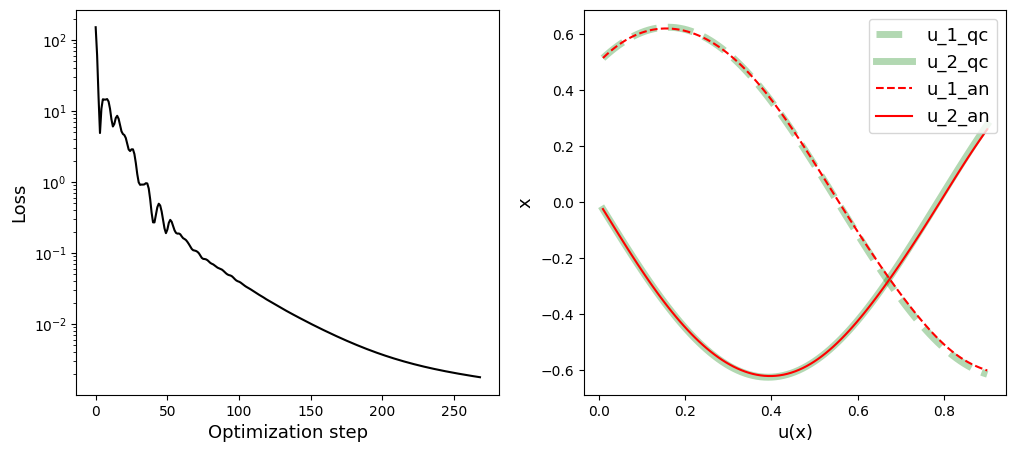

Step: 270  Loss: 0.0017742104328301242


KeyboardInterrupt: 

In [2]:
# %timeit -n1 -r1 
opt.param_groups[0]["lr"] = 0.1
optimize(n_iter=500, verbose=2)
opt.param_groups[0]["lr"] = 0.01
optimize(n_iter=100, verbose=2)
